# <span style='font-family:Comic Sans MS'> Credit Card Fraud Detection (Supervised learning)
   <span style='font-family:Comic Sans MS'> by Ori Rosenthal

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score,confusion_matrix, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### <span style='font-family:Comic Sans MS'>Content
<span style='font-family:Comic Sans MS'>The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

<span style='font-family:Comic Sans MS'>It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
df = pd.read_csv(r'c:/Users/User/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

### <span style='font-family:Comic Sans MS'>Clean DataSet. no Null values

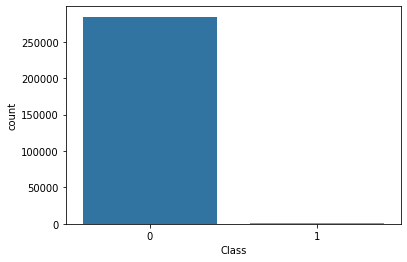

In [5]:
# Class: 1 fraud, 0 not fraud
sns.countplot(x='Class',data=df)
plt.show();

In [6]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

#### <span style='font-family:Comic Sans MS'>Only 0.172% for class 1 (1.72 fraudulent transactions in every 1000 entities).

## <span style='font-family:Comic Sans MS'>Feature Selection (choosing the most relevant features)

### <span style='font-family:Comic Sans MS'><u>Feature - Class relationships</u>:

<span style='font-family:Comic Sans MS'>* Let's explore and visualize the distribution and relationships between features and targets,<br>
Normal transactions (class 0) -> <b><font color='green'>green</font></b><br>
Fraudlent transactions (class 1) -> <b><font color='red'>red</font></b>

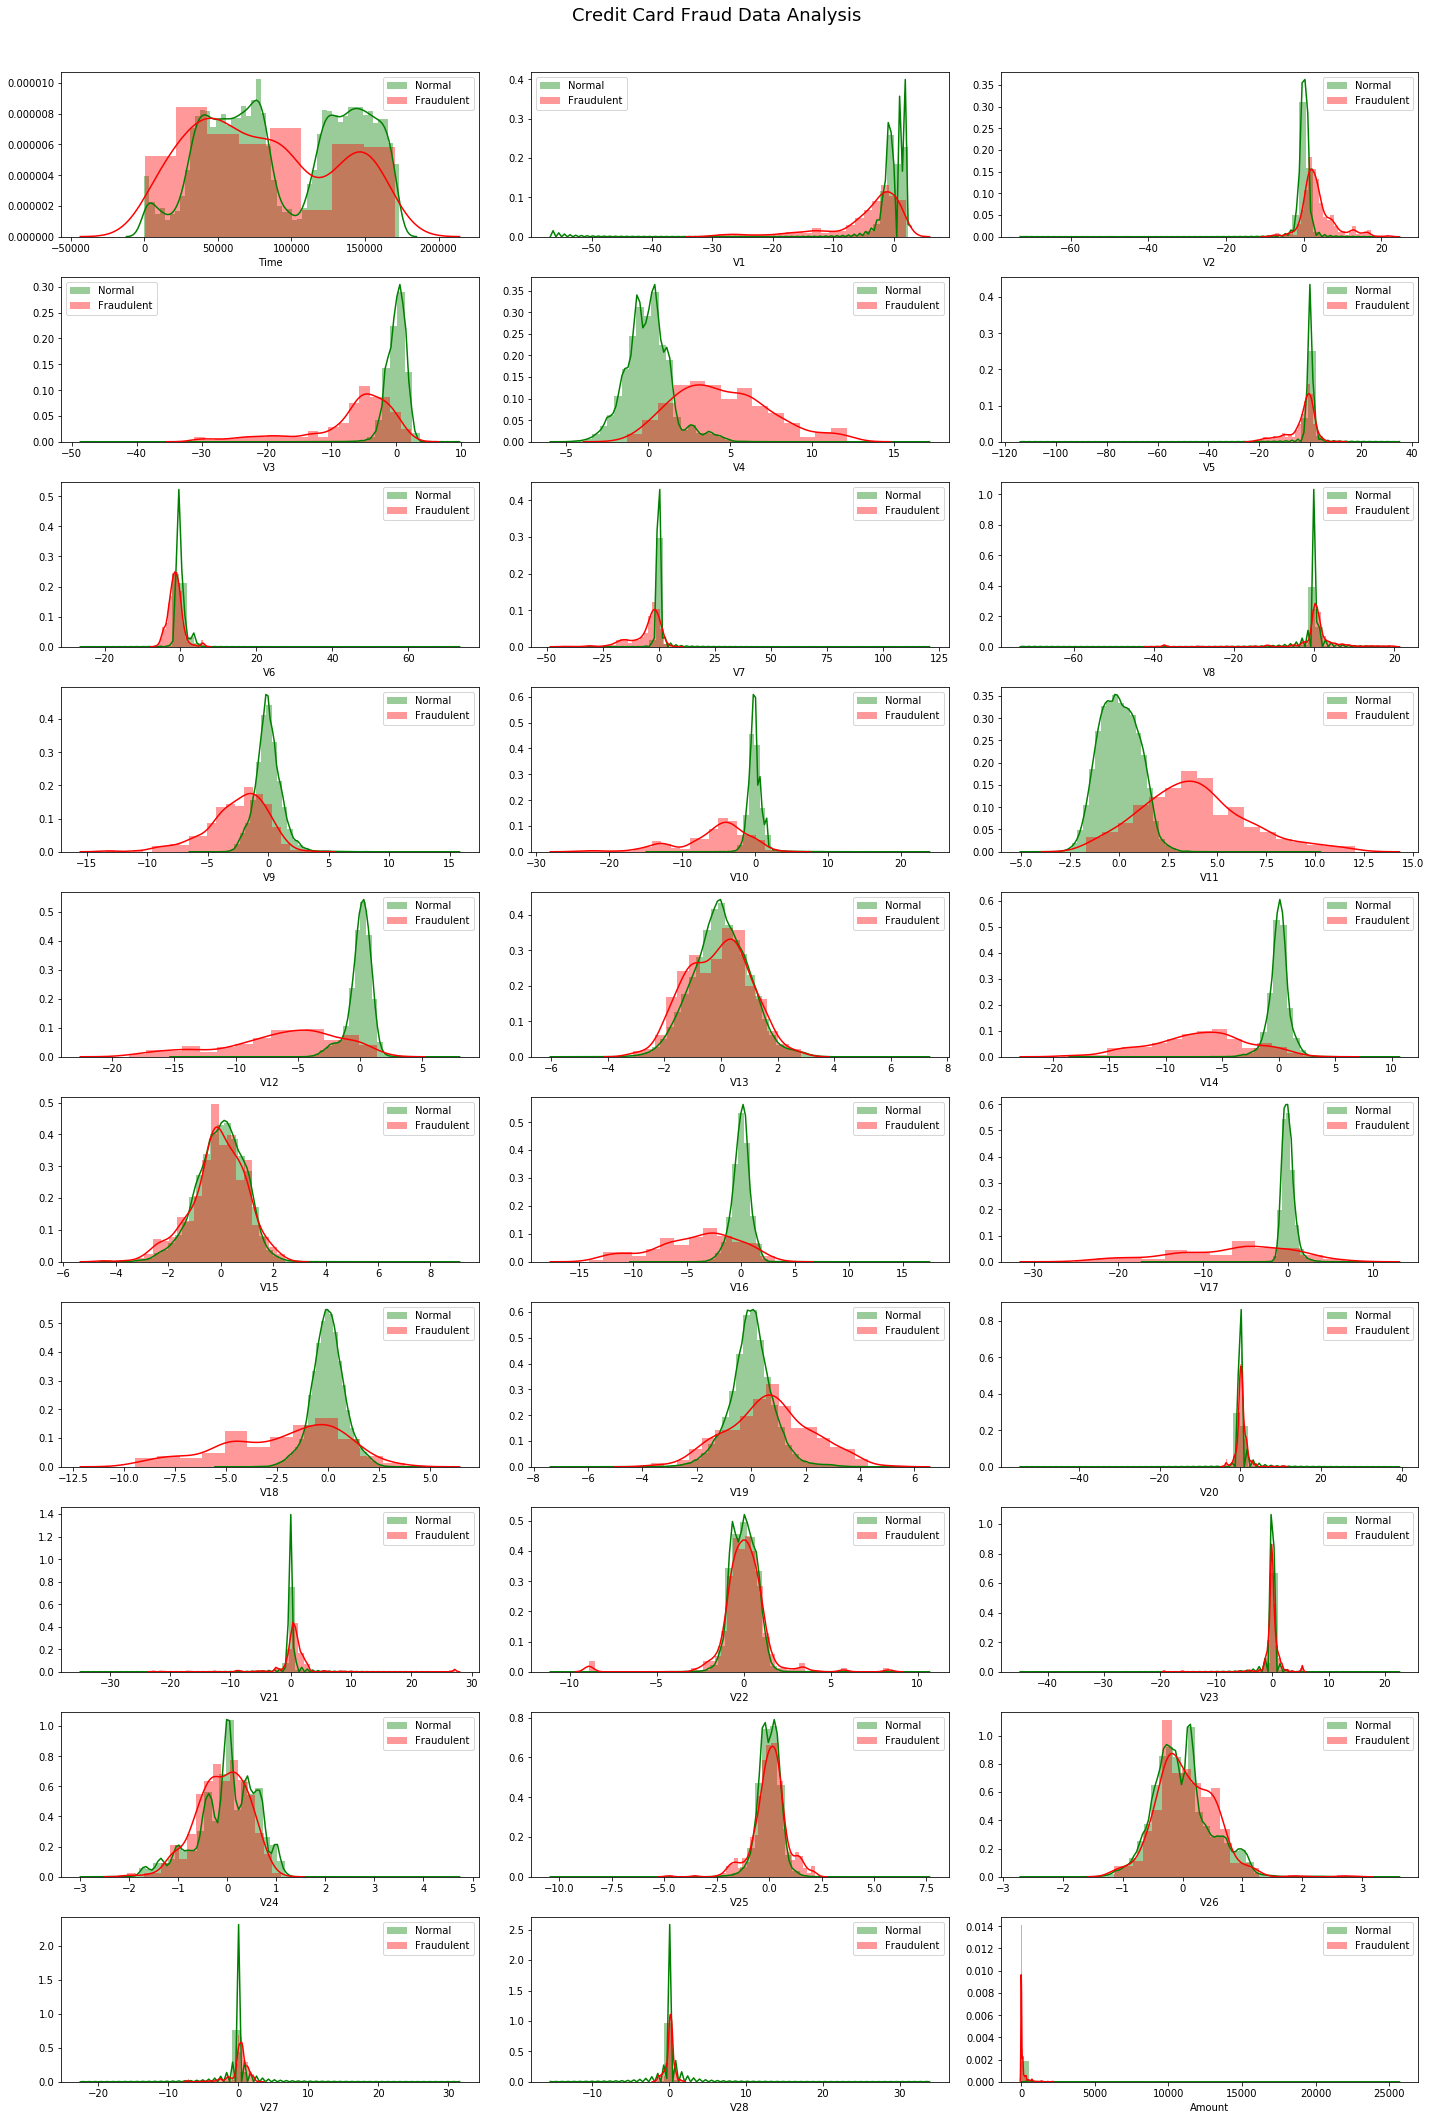

In [7]:
features_dist = df.drop('Class', axis=1)
fig = plt.figure(figsize = (20, 30))
j = 0
for i in features_dist.columns:
    plt.subplot(10, 3, j+1)
    j += 1
    sns.distplot(df[df['Class']==0][i], color='g', label = 'Normal')
    sns.distplot(df[df['Class']==1][i], color='r', label = 'Fraudulent')
    plt.legend(loc='best')
fig.suptitle('Credit Card Fraud Data Analysis',fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

<span style='font-family:Comic Sans MS'>For example, if we look at the ' V15 ' or ' V22 ' features, we can see that the outliers are not isolated from the usual transactions for those feature distributions.

In [8]:
# Standardize features by removing the mean and scaling to unit variance
std_scaler = StandardScaler()
df_std = std_scaler.fit_transform(df.drop('Class', axis=1))
df_std = pd.DataFrame(df_std)
df_std = pd.concat([df_std, df[['Class']]],axis=1)
df_std.columns = df.columns.tolist()
df_std.head()    

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


### <span style='font-family:Comic Sans MS'>Let's look for features that are correlated with the target 

In [9]:
# features correlation to outpot classifier
abs(df_std.corr()['Class']).sort_values(ascending=False)

Class     1.000000
V17       0.326481
V14       0.302544
V12       0.260593
V10       0.216883
V16       0.196539
V3        0.192961
V7        0.187257
V11       0.154876
V4        0.133447
V18       0.111485
V1        0.101347
V9        0.097733
V5        0.094974
V2        0.091289
V6        0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time      0.012323
V28       0.009536
V24       0.007221
Amount    0.005632
V13       0.004570
V26       0.004455
V15       0.004223
V25       0.003308
V23       0.002685
V22       0.000805
Name: Class, dtype: float64

In [10]:
# Selecting above 0.1 
model_features = abs(df_std.corr()['Class']).sort_values(ascending=False).index[1:12].tolist()

In [11]:
model_features

['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1']

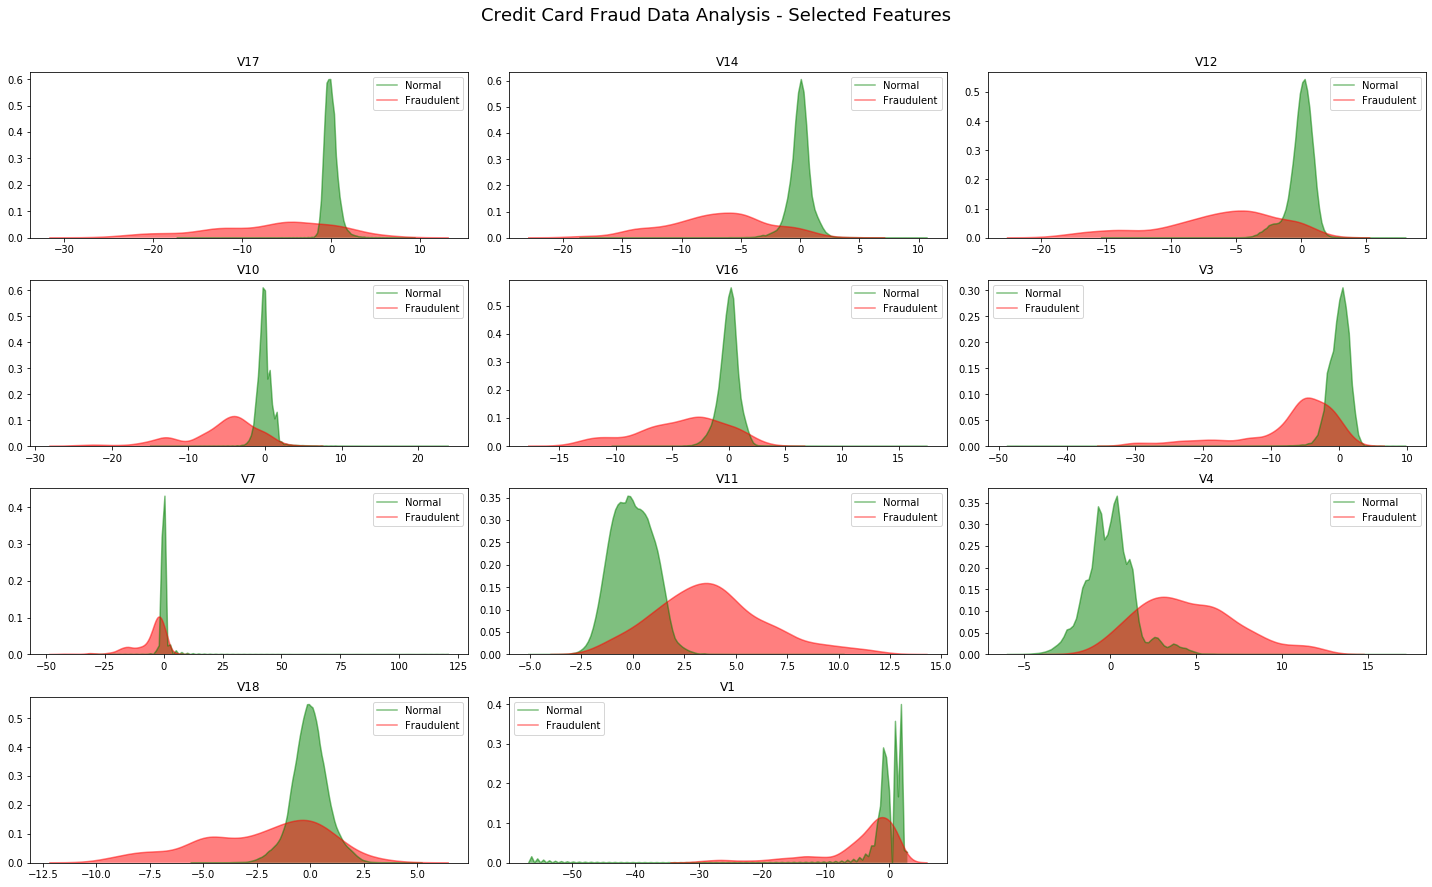

In [12]:
# Visualized again the selected features Class distribution 
fig = plt.figure(figsize = (20, 30))
j = 0
for i in model_features:
    plt.subplot(10, 3, j+1)
    j += 1
    sns.kdeplot(df[df['Class']==0][i], color='g', shade=True, label = 'Normal', alpha=0.5)
    sns.kdeplot(df[df['Class']==1][i], color='r', shade=True,label = 'Fraudulent', alpha=0.5)
    plt.title(i)
    plt.legend(loc='best')
fig.suptitle('Credit Card Fraud Data Analysis - Selected Features',fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### <span style='font-family:Comic Sans MS'> As we can see, the relativity correlated features to target are those that able to separate the outliers fraudulent from inliers

In [13]:
# Split the dfset to X(features) and y(target) before assigning the train and test df.  
X = df_std[model_features]
y = df_std['Class']

In [14]:
# Split the df to train/test. We will train 0.75  * length and test our Classifier on the rest (the test df_std). 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### <span style='font-family:Comic Sans MS'><u>Model creation</u>

<span style='font-family:Comic Sans MS'>The credit card fraud prediction is a binary classification problem,<br> in this example I will use the Random Forest Classifier, set to the default parameters except for the class_weight<br>because  the proportion of the positive and negative samples is extremely uneven and imbalanced.<br>The (class_weight="balanced") mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\downarrow$
## $\frac{N samples}{N classes \times\ np.bincount(y))}$

In [15]:
rf_clf = RandomForestClassifier(class_weight="balanced", random_state=111).fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

In [16]:
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=111,
                       verbose=0, warm_start=False)

### <span style='font-family:Comic Sans MS'> Model evaluation metrics

In [17]:
#  mean accuracy
np.round(rf_clf.score(X_test,y_test),4)

0.9994

In [18]:
# Precision score (TP/(TP+FP))
cm = confusion_matrix(y_test,y_pred)
print(f'{precision_score(y_test, y_pred)*100:.2f}% of all predicted as fraudulent by the model were relevant.')
print(f'In other words, the model predict {cm[0][1] + cm[1][1]} \
transactions as fraudulent, which {cm[1][1]} of them actually were.')

93.20% of all predicted as fraudulent by the model were relevant.
In other words, the model predict 103 transactions as fraudulent, which 96 of them actually were.


In [19]:
# Recall score (TP/(TP+FN))
y_pred = rf_clf.predict(X_test)
print(f'The model correctly identifies {recall_score(y_test, y_pred)*100:.2f}% of all fraudulent transactions \
({cm[1][1]} out of {cm[1].sum()})')

The model correctly identifies 74.42% of all fraudulent transactions (96 out of 129)


In [20]:
# AUC score
y_pred = rf_clf.predict(X_test)
np.round(roc_auc_score(y_test, y_pred),4)

0.872

#### <span style='font-family:Comic Sans MS'>* By Using only the default setting of the classifier, we have achieved relatively great results.

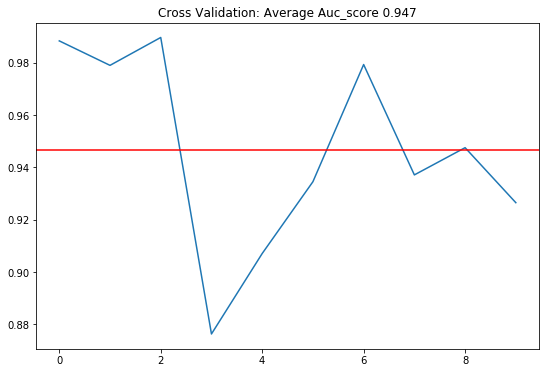

In [21]:
# preforming cross validation on AUC metric
cv = cross_validate(rf_clf, X, y,scoring='roc_auc', cv=10)

plt.figure(figsize=(9,6))    
plt.plot(cv['test_score']); 
plt.axhline(np.mean(cv['test_score']), color='r');
plt.title(f"Cross Validation: Average Auc_score {round(np.mean(cv['test_score']),3)}");

<span style='font-family:Comic Sans MS'><b>The score of ROC_AUC measures the ability of the model to distinguish between the classes.<br>We'll later use it to compare the models

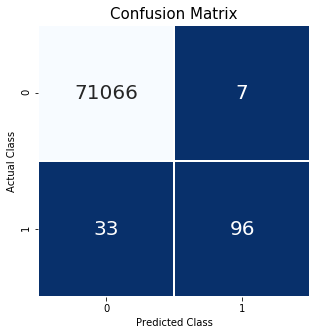

In [22]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":20}); 

# labels, title and ticks
plt.ylabel('Actual Class');
plt.xlabel('Predicted Class');
plt.title('Confusion Matrix', fontsize=15); 


### <span style='font-family:Comic Sans MS'> Features importance

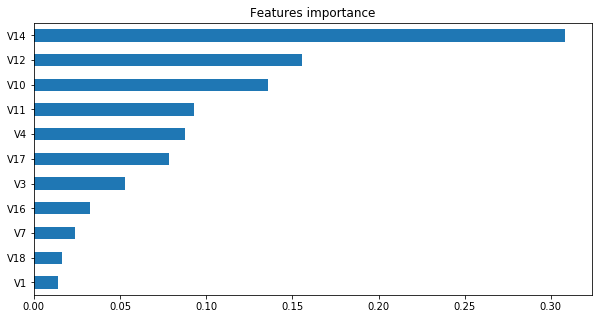

In [23]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', title='Features importance', figsize=(10,5))
plt.show()

### <span style='font-family:Comic Sans MS'>Hyperparameter Tuning the Random Forest

<span style='font-family:Comic Sans MS'>Let' try to improve our model performancewe buy tuning the hyperparameters (parameters whose values are used to control the learning process).<br>We will try many different combinations to evaluate the performance of each model, which include the number of decision trees in the forest,<br>max number of features considered for splitting a node max number of levels in each decision tree, the min number of data points allowed in a leaf node and min number of data points placed in a node before the node is split.

In [24]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [3,4,5,6],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [25]:
CV_rfc = GridSearchCV(estimator=rf_clf, param_grid=param_grid,verbose=2, cv= 4, scoring='roc_auc', n_jobs=-1)
CV_rfc.fit(X_train, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 159.4min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=111,
                           

<span style='font-family:Comic Sans MS'><b>Let's get the  parameter setting that gave the best results:

In [26]:
CV_rfc.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [27]:
rf_clf1 = RandomForestClassifier(class_weight="balanced",
                                n_estimators=200, min_samples_leaf=2, min_samples_split=10,
                                max_depth=6, max_features='auto').fit(X_train,y_train)

In [28]:
# AUC score
y_pred_clf1 = rf_clf1.predict(X_test)
np.round(roc_auc_score(y_test, y_pred_clf1),4)

0.9173

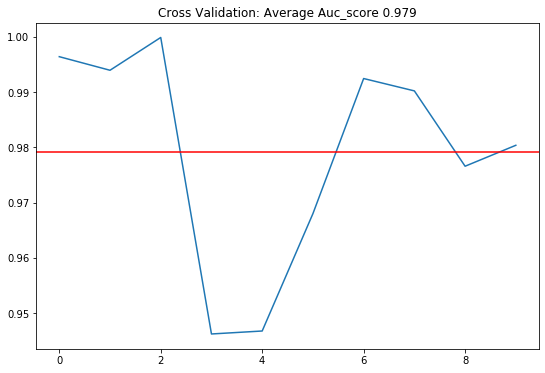

In [30]:
# preforming cross validation on AUC metric for the new settings
cv1 = cross_validate(rf_clf1, X, y,scoring='roc_auc', cv=10)

plt.figure(figsize=(9,6))    
plt.plot(cv1['test_score']); 
plt.axhline(np.mean(cv1['test_score']), color='r');
plt.title(f"Cross Validation: Average Auc_score {round(np.mean(cv1['test_score']),3)}");

### <span style='font-family:Comic Sans MS'>The hyperparameter tuning improved the ROC_AUC Score from 0.947 to 0.979 